In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../data/processed/dataset_processed.csv")

X = df.iloc[:, :51].drop(columns=['file_path'])
Y = df.iloc[:, 51:]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle=True)

In [3]:
print("Dataset shape: ", df.shape)
print(f"✓ Training set: {X_train.shape}")
print(f"✓ Test set: {X_test.shape}")

Dataset shape:  (3088, 64)
✓ Training set: (2161, 50)
✓ Test set: (927, 50)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Dataset shape: ", df.shape)
print(f"✓ Training set: {X_train.shape}")
print(f"✓ Test set: {X_test.shape}")

Dataset shape:  (3088, 64)
✓ Training set: (2470, 50)
✓ Test set: (618, 50)


In [5]:
xgb_model = xgb.XGBClassifier()

xgb_model.fit(X_train, y_train, verbose=False)
print("✓ XGBoost model trained!")

✓ XGBoost model trained!


In [6]:
y_pred_baseline_train = xgb_model.predict(X_train)
y_pred_baseline_test = xgb_model.predict(X_test)

In [7]:
train_acc = accuracy_score(y_train, y_pred_baseline_train)
test_acc = accuracy_score(y_test, y_pred_baseline_test)

print(f"  Training Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")

  Training Accuracy: 0.9996
  Test Accuracy: 0.9175


In [8]:
print("\nClassification Report:")
print("-" * 60)
print(classification_report(y_test, y_pred_baseline_test, target_names=Y.columns, zero_division=0))


Classification Report:
------------------------------------------------------------
                      precision    recall  f1-score   support

       y_FeatureEnvy       1.00      0.99      0.99       214
  y_FormattingIssues       0.94      0.91      0.92       250
  y_GlobalStateAbuse       1.00      1.00      1.00        36
          y_GodClass       0.86      0.83      0.84        23
y_LargeParameterList       1.00      1.00      1.00       352
         y_LazyClass       1.00      1.00      1.00        95
        y_LongMethod       1.00      1.00      1.00       150
y_MisleadingComments       1.00      1.00      1.00       221
 y_PoorDocumentation       1.00      1.00      1.00       398
     y_SpaghettiCode       1.00      1.00      1.00        21
    y_UnstableModule       1.00      0.94      0.97        16
      y_UntestedCode       1.00      1.00      1.00       226
         y_any_smell       0.99      1.00      0.99       543

           micro avg       0.99      0.99    

Confusion Matrices:


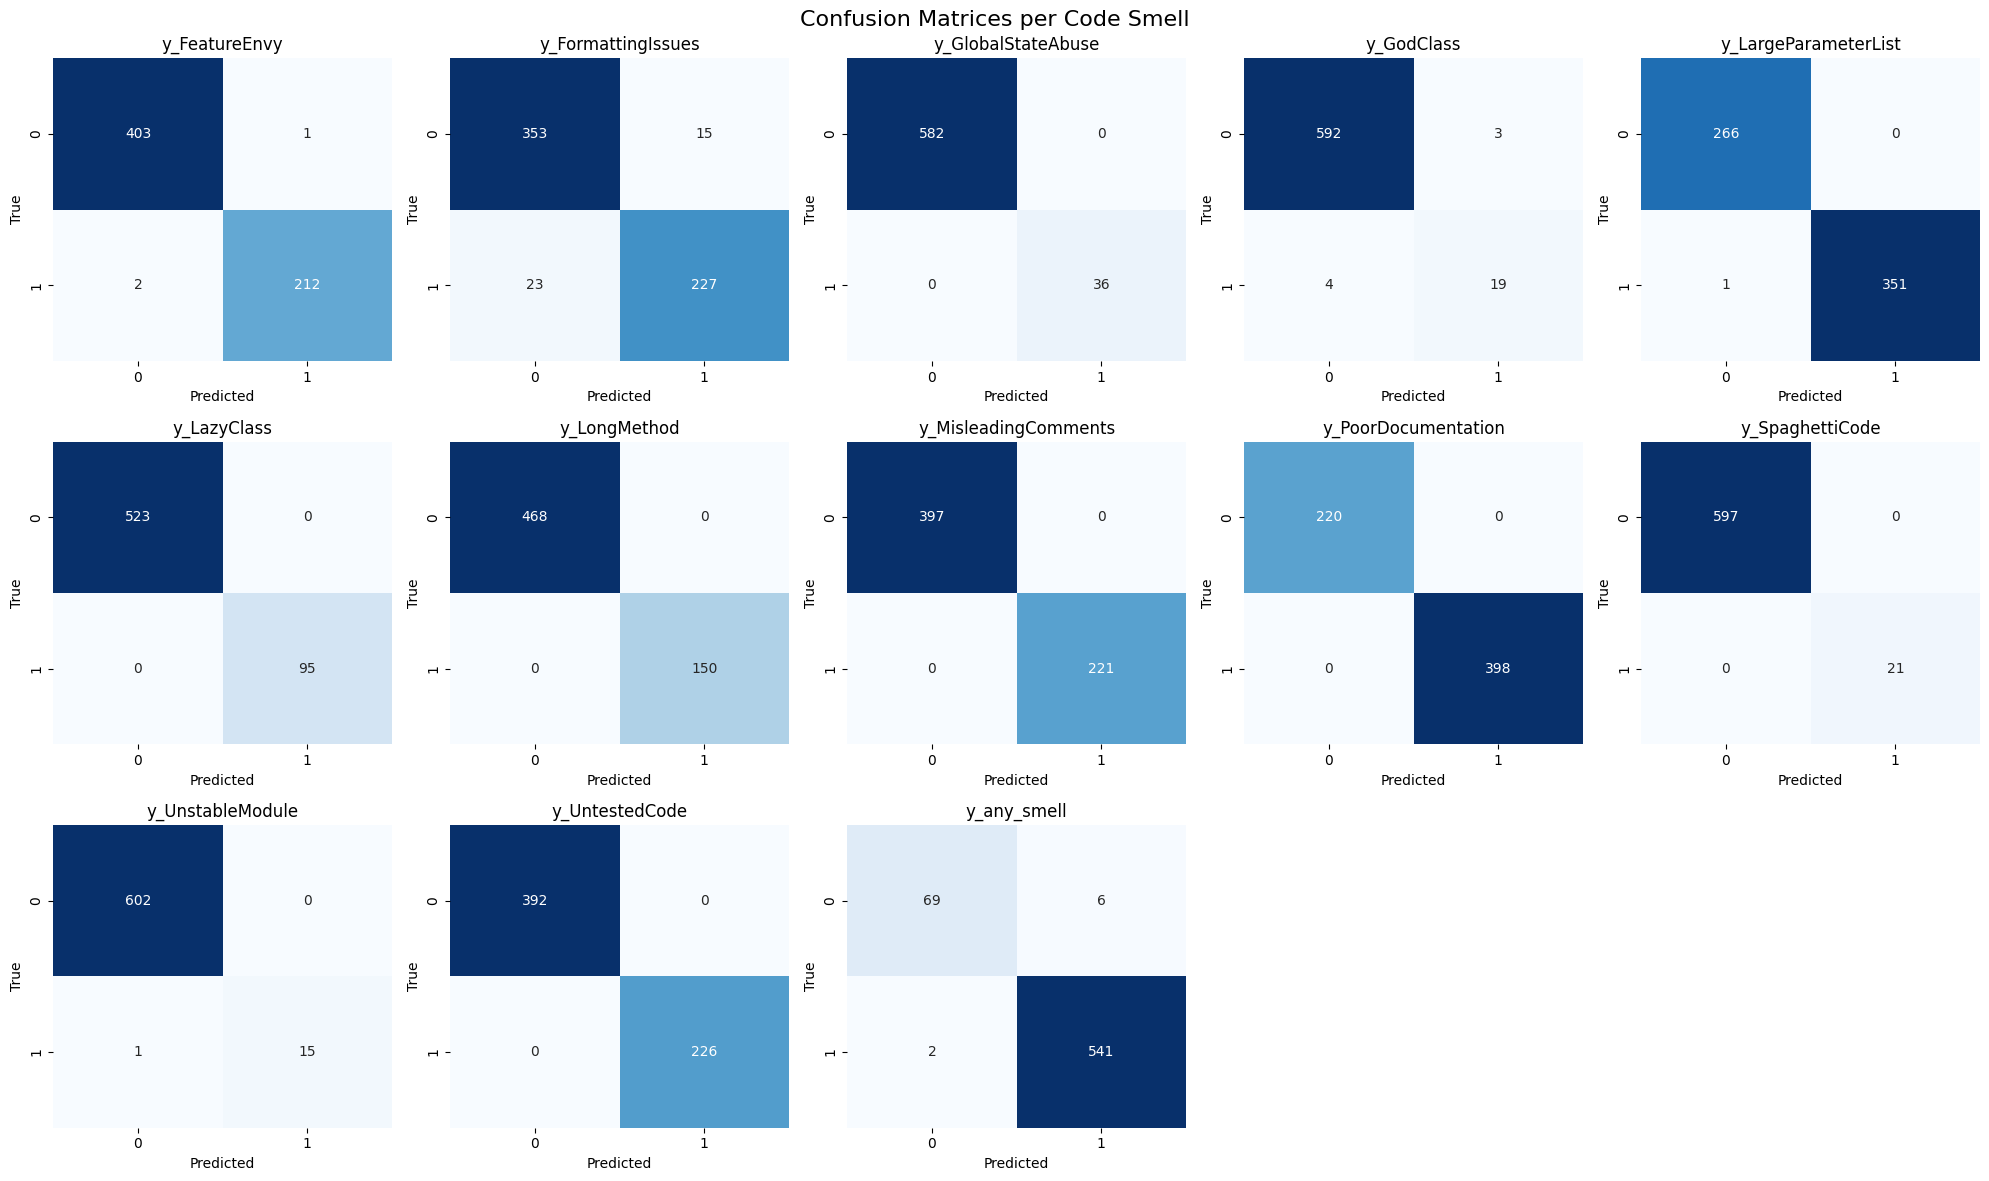

In [9]:
print("Confusion Matrices:")
target_cols = y_test.columns
mcm_baseline = multilabel_confusion_matrix(y_test, y_pred_baseline_test)

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.ravel()

for i, (col, cm) in enumerate(zip(target_cols, mcm_baseline)):
    if i < len(axes):
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues', cbar=False)
        axes[i].set_title(f'{col}')
        axes[i].set_ylabel('True')
        axes[i].set_xlabel('Predicted')

# Hide extra subplots
for j in range(len(target_cols), len(axes)):
    axes[j].axis('off')

plt.suptitle('Confusion Matrices per Code Smell', fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}

multi_output_estimator = MultiOutputClassifier(xgb_model)

In [11]:
grid_search = GridSearchCV(
    estimator=multi_output_estimator,
    param_grid={'estimator__' + key: value for key, value in param_grid.items()},
    scoring='f1_micro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


KeyboardInterrupt: 

In [ ]:
print("Best Parameters:")
best_params = {k.replace('estimator__', ''): v for k, v in grid_search.best_params_.items()}
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation F1-Score (Micro): {grid_search.best_score_:.4f}")

In [ ]:
print("Tuned Model Evaluation...")

tuned_model = grid_search.best_estimator_

y_pred_tuned_train = tuned_model.predict(X_train)
y_pred_tuned_test = tuned_model.predict(X_test)

tuned_train_acc = accuracy_score(y_train, y_pred_tuned_train)
tuned_test_acc = accuracy_score(y_test, y_pred_tuned_test)

print(f"  Training Accuracy: {tuned_train_acc:.4f}")
print(f"  Test Accuracy: {tuned_test_acc:.4f}")

In [ ]:
print("Classification Report")
print("-" * 60)
print(classification_report(y_test, y_pred_tuned_test, target_names=target_cols, zero_division=0))

In [ ]:
print("Tuned Model Confusion Matrices")
print("-" * 60)
mcm_tuned = multilabel_confusion_matrix(y_test, y_pred_tuned_test)

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
axes = axes.ravel()

for i, (col, cm) in enumerate(zip(target_cols, mcm_tuned)):
    if i < len(axes):
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Greens', cbar=False)
        axes[i].set_title(f'{col}')
        axes[i].set_ylabel('True')
        axes[i].set_xlabel('Predicted')

# Hide extra subplots
for j in range(len(target_cols), len(axes)):
    axes[j].axis('off')

plt.suptitle('Tuned Model - Confusion Matrices per Code Smell', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
print("BASELINE vs TUNED MODEL COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Tuned'],
    'Training Accuracy': [train_acc, tuned_train_acc],
    'Test Accuracy': [test_acc, tuned_test_acc],
    'Improvement': [0, tuned_test_acc - test_acc]
})

print("\n", comparison_df.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
models = ['Baseline', 'Tuned']
x = np.arange(len(models))
width = 0.35

ax.bar(x - width/2, [train_acc, tuned_train_acc], width, label='Training', alpha=0.8)
ax.bar(x + width/2, [test_acc, tuned_test_acc], width, label='Test', alpha=0.8)

ax.set_ylabel('Accuracy')
ax.set_title('Baseline vs Tuned Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()

In [ ]:
print("Feature Importance Analysis")

# Extract first estimator for feature importance
first_estimator = tuned_model.estimators_[0]
importance = first_estimator.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': Y.columns,
    'importance': importance
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_df.head(15).to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Importance Score')
plt.title('Top 20 Feature Importance (Tuned XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# Load the model
with open('dataset_xgboost_tuned.pkl', 'rb') as f:
    xgb_m = pickle.load(f)